<a href="https://colab.research.google.com/github/katehee/X-ray_pneumonia_classification/blob/master/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
from tqdm import tqdm
from skimage.io import imread
import random 
random.seed(0)

from tensorflow.keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
import cv2

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base = "/content/drive/MyDrive/Pneumonia/"
train_dir = base + "train/"
test_dir = base + "test/"
val_dir = base + "val/"

print("Train set:\n========================================")
num_pneumonia = os.listdir(os.path.join(train_dir, 'PNEUMONIA')) #pneumonia image file names
num_normal = os.listdir(os.path.join(train_dir, 'NORMAL'))
print(f"PNEUMONIA={len(num_pneumonia)}")
print(f"NORMAL={len(num_normal)}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

Train set:
PNEUMONIA=3933
NORMAL=1359
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


## Exploratory analysis

###charts
- pneumonia vs normal 
- pneumonia type (bacteria vs virus) pie chart

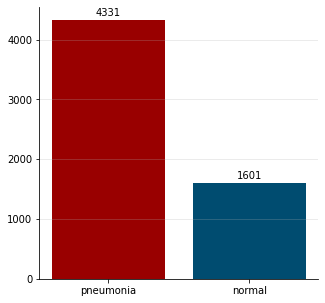

In [83]:
total_num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA'))) + len(os.listdir(os.path.join(test_dir, 'PNEUMONIA'))) + len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
total_num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL'))) + len(os.listdir(os.path.join(test_dir, 'NORMAL'))) + len(os.listdir(os.path.join(val_dir, 'NORMAL')))

#bar-chart pneumonia vs normal 
fig, ax =  plt.subplots(figsize = (5, 5))
ax.bar(['pneumonia','normal'], [total_num_pneumonia, total_num_normal], color = ('#990000', '#004c70'))
for s in ["top","right"]:
    ax.spines[s].set_visible(False)

#annotate y-value
for bar in ax.patches: 
  ax.annotate(f"{bar.get_height():.0f}", 
                   xy = (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 7), 
                   textcoords = 'offset points')

# y-axis tick
grid_y_ticks = np.arange(0, 4400, 1000)
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y', linestyle='-', alpha=0.3)


total_pneumonia_cases:  4331
virus count:  1520
bacteria count:  2811


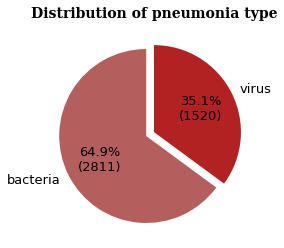

In [113]:
total_pneumonia_filenames = os.listdir(os.path.join(train_dir, 'PNEUMONIA')) + os.listdir(os.path.join(test_dir, 'PNEUMONIA')) + os.listdir(os.path.join(val_dir, 'PNEUMONIA'))
total_pneumonia_filenames
virus_cnt, bacteria_cnt = 0, 0
for pneumonia_filename in total_pneumonia_filenames: 
  p_type = pneumonia_filename.split('_')[1]
  if p_type == "virus": 
    virus_cnt += 1
  elif p_type == "bacteria": 
    bacteria_cnt += 1
print("total_pneumonia_cases: ", len(total_pneumonia_filenames))
print("virus count: ", virus_cnt)
print("bacteria count: ",bacteria_cnt)

#distribution of pneumonia type - pie chart
y = [bacteria_cnt, virus_cnt]
labels = ["bacteria", "virus"]
colors = ['#b55e5e','#b22222']
myexplode = [0.1, 0]
def prob(x): 
  return '{:.1f}'.format(x) + '%' + "\n" + '(' + '{:.0f}'.format(x/100 * 4331) + ')'

plt.title("Distribution of pneumonia type", fontsize=14, fontweight='bold', fontfamily='serif')
plt.pie(y, labels=labels, startangle=90, colors=colors, explode=myexplode, autopct=prob, textprops={'fontsize': 13})
plt.show()

###show images
- pneumonia images
- normal images

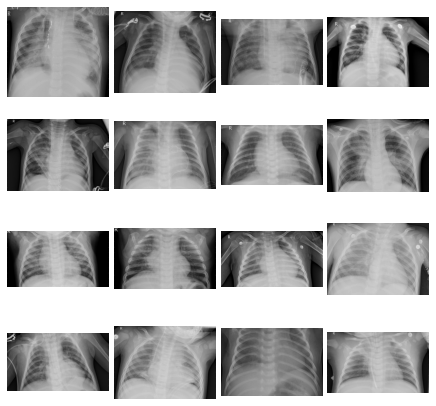

In [4]:
def show_images(dir, label, size): 
  image_names = os.listdir(os.path.join(dir, label))
  selected_images = random.sample(image_names, size*size) #random select 

  plt.figure(figsize=(6,6))
  for i in range(size*size): 
    plt.subplot(size, size, i + 1)
    image = plt.imread(os.path.join(os.path.join(dir, label), selected_images[i]))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
  plt.tight_layout(pad=0.5)

show_images(train_dir, label="PNEUMONIA", size=4) #generate size * size image plot 

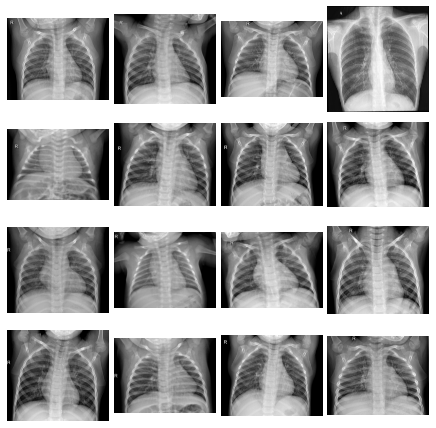

In [5]:
show_images(train_dir, label="NORMAL", size=4)

###pixel distribution

In [159]:
p_dir = base + "train/PNEUMONIA/" 
p_files = os.listdir(os.path.join(train_dir,'PNEUMONIA'))
p_images_mean = []
for p_file in tqdm(p_files): 
  sample_img = plt.imread(os.path.join(p_dir, p_file))
  p_images_mean.append(int(sample_img.mean()))

100%|██████████| 3933/3933 [00:30<00:00, 127.80it/s]


In [163]:
n_dir = base + "train/NORMAL/" 
n_files = os.listdir(os.path.join(train_dir,'NORMAL'))
n_images_mean = []
for n_file in tqdm(n_files): 
  sample_img = plt.imread(os.path.join(n_dir, n_file))
  n_images_mean.append(int(sample_img.mean()))

100%|██████████| 1359/1359 [00:31<00:00, 42.70it/s]


<Figure size 720x720 with 0 Axes>

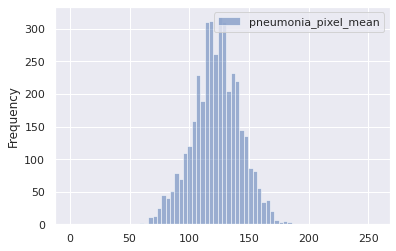

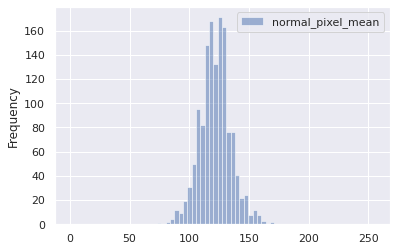

In [178]:
p_df = pd.DataFrame(p_images_mean, columns = ['pneumonia_pixel_mean']).sort_values(by='pneumonia_pixel_mean').reset_index(drop=True)
n_df = pd.DataFrame(n_images_mean, columns = ['normal_pixel_mean']).sort_values(by='normal_pixel_mean').reset_index(drop=True)
plt.figure(figsize=(10,10))
p_df.plot.hist(bins=70, alpha=0.5, range=[0,255])
n_df.plot.hist(bins=70, alpha=0.5, range=[0,255])